## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# 神經網絡正規化
from keras.regularizers import l1, l2, l1_l2

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 3s 0us/step


# 資料前處理 - 標準化 及 獨熱編碼(OneHot Encoding)

In [0]:
def preproc_x( x, flatten = True ) :
    x = x / 255.
    if flatten:
        x = x.reshape( ( len(x), -1 ) )
    return x

def preproc_y( y, num_classes = 10 ) :
    if y.shape[ -1 ] == 1:
        y = keras.utils.to_categorical( y, num_classes )
    return y  

In [0]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

# 建立神經網絡模型( L1- Regularization )

In [5]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], l1_parameter = 0 ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ),
                                    name = "hidden_layer_" + str( i+1 ) )( input_layer )
        else:
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1( l1_parameter ), 
                                    name = "hidden_layer_" + str( i+1 ) )( x )
    
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'output_layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

W0716 15:29:21.424849 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 15:29:21.465273 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 15:29:21.476758 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


## 設定超參數

In [0]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95  
L1_PARAMETER = [ 1e-2, 1e-4, 1e-8, 1e-12 ]

## 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

## 訓練模型

In [8]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for l1_parameter in L1_PARAMETER :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'L1 Parameters = ' + str( l1_parameter ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ],
                       l1_parameter = l1_parameter
                       )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "L1_para.-%s" % str( l1_parameter )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

W0716 15:29:21.598492 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0716 15:29:21.600587 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 15:29:21.679201 140292099504000 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



L1 Parameters = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0716 15:29:21.868082 140292099504000 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 14s 282us/step - loss: 259.0556 - acc: 0.2342 - val_loss: 139.5187 - val_acc: 0.2694
Epoch 2/50
50000/50000 [==============================] - 13s 265us/step - loss: 73.0177 - acc: 0.2421 - val_loss: 31.4285 - val_acc: 0.1625
Epoch 3/50
50000/50000 [==============================] - 13s 256us/step - loss: 22.6105 - acc: 0.1052 - val_loss: 15.3982 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 13s 258us/step - loss: 10.5580 - acc: 0.0997 - val_loss: 6.7642 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 13s 259us/step - loss: 5.1267 - acc: 0.1000 - val_loss: 4.1251 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 13s 259us/step - loss: 3.6093 - acc: 0.0964 - val_loss: 3.2500 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 13s 260us/step - loss: 3.1831 - acc: 0.0995 - val

## 損失函數及準確率

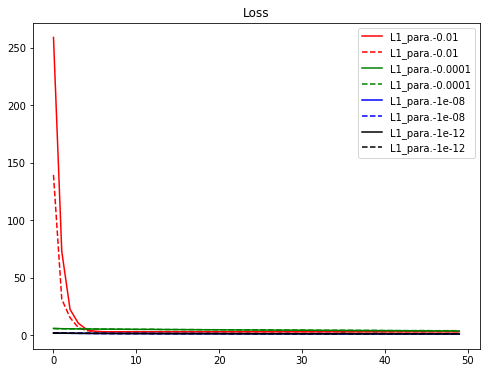

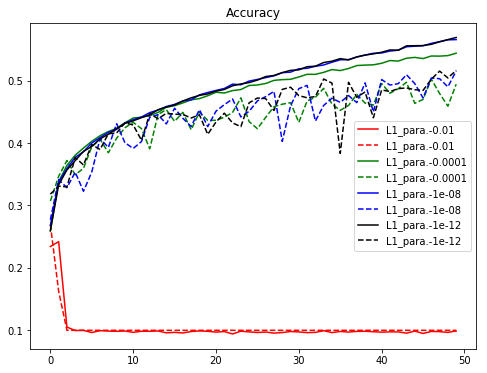

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = [ 'r', 'g', 'b', 'k' ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = cond, color = color_bar[i] )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = cond, color = color_bar[i] )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = cond, color = color_bar[i] )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )

# 建立神經網絡模型( L1_L2 - Regularization )

In [11]:
def build_mlp( input_shape, output_units = 10, num_neurons = [ 512, 256, 128 ], l1_l2_parameter = 0 ) : 
    
    input_layer = keras.layers.Input( input_shape )
    
    for i, n_units in enumerate( num_neurons ) : 
        if i == 0 :
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1_l2( l1_l2_parameter ),
                                    name = "hidden_layer_" + str( i+1 ) )( input_layer )
        else:
            x = keras.layers.Dense( units = n_units, 
                                    activation = "relu", 
                                    kernel_regularizer = l1_l2( l1_l2_parameter ), 
                                    name = "hidden_layer_" + str( i+1 ) )( x )
    
    output_layer = keras.layers.Dense( units = output_units, 
                                       activation = 'softmax', 
                                       name = 'output_layer' )( x )
    
    model = keras.models.Model( inputs = [ input_layer ], outputs = [ output_layer ] )
    return model

model = build_mlp( input_shape = x_train.shape[ 1: ] ) 
model.summary( )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


## 設定超參數

In [0]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95  
L1_L2_PARAMETER = [ 1e-2, 1e-4, 1e-8, 1e-12 ]

## 優化器(Optimizer)

In [0]:
SGD = keras.optimizers.SGD( lr = LEARNING_RATE, 
                            momentum = MOMENTUM, 
                            nesterov = True
                            )

Optimizers = 'SGD'

## 訓練模型

In [14]:
results = {}

"""
建立訓練與實驗迴圈並蒐集資料
"""
for l1_l2_parameter in L1_L2_PARAMETER :
    keras.backend.clear_session( )    # 清掉舊的 Graph 
    
    print( 'L1_L2 Parameters = ' + str( l1_l2_parameter ) )
    model = build_mlp( input_shape = x_train.shape[ 1: ],
                       l1_l2_parameter = l1_l2_parameter
                       )
    model.summary( )
    
    
    # 執行神經網絡
    model.compile( loss = 'categorical_crossentropy', 
                   optimizer = Optimizers, 
                   metrics=[ 'accuracy' ] 
                   )

    model.fit( x_train, y_train, 
               epochs = EPOCHS,     
               batch_size = BATCH_SIZE, 
               validation_data = ( x_test, y_test ), 
               shuffle = True
               )
    
    # Collect results
    train_loss = model.history.history[ 'loss' ]
    valid_loss = model.history.history[ 'val_loss' ]
    train_acc = model.history.history[ 'acc' ]
    valid_acc = model.history.history[ 'val_acc' ]
    
    exp_name_tag = "L1_L2_para.-%s" % str( l1_l2_parameter )
    results[ exp_name_tag ] = { 'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc
                                }

L1_L2 Parameters = 0.01
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 256)               131328    
_________________________________________________________________
hidden_layer_3 (Dense)       (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 

## 損失函數及準確率

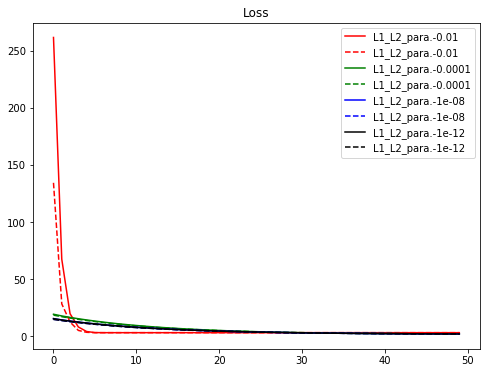

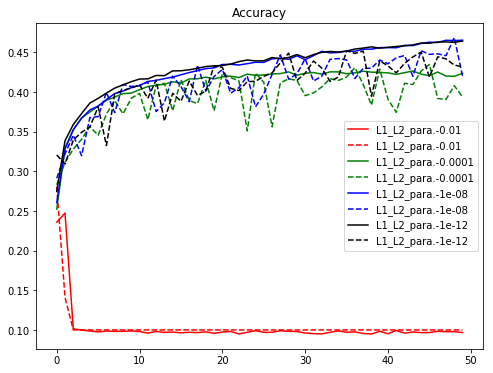

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = [ 'r', 'g', 'b', 'k' ]

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot( range( len(results[ cond ][ 'train-loss' ] ) ), results[ cond ][ 'train-loss' ], '-', label = cond, color = color_bar[i] )
    plt.plot( range( len(results[ cond ][ 'valid-loss' ] ) ), results[ cond ][ 'valid-loss' ], '--', label = cond, color = color_bar[i] )
plt.title( 'Loss' )
plt.legend( )
plt.show( )

plt.figure( figsize = ( 8, 6 ) )
for i, cond in enumerate( results.keys( ) ) :
    plt.plot(range( len( results[ cond ][ 'train-acc' ] ) ), results[ cond ][ 'train-acc' ], '-', label = cond, color = color_bar[i] )
    plt.plot(range( len( results[ cond ][ 'valid-acc' ] ) ), results[ cond ][ 'valid-acc' ], '--', label = cond, color = color_bar[i] )
plt.title( 'Accuracy' )
plt.legend( )
plt.show( )